## Portland House Group 
### Quantitative Researcher Test

Test provided date : 6 November 2019

Test due date : Two weeks (20 November 2019)

####  Importing Stock Price Data files

In [13]:
import os
from glob import glob
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter
import time
from scipy import stats
from datetime import datetime
from tqdm import tqdm    # for checking progress of a loop
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

%matplotlib inline

#### Importing data

In [14]:
path  = r'E:/GoogleDrive1/UoM/MyDocs/JobApps/Portland_House/ASX-2015-2018/'
files = glob(path + '/*.txt')
agg_frame = pd.concat([pd.read_csv(f, header = None, names=['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'],error_bad_lines=False) for f in files], ignore_index=True)
agg_frame.head()

,Ticker,Date,Open,High,Low,Close,Volume
0,1PG,20150102,1.195,1.240,1.16,1.215,607639
1,3PL,20150102,2.290,2.290,2.17,2.260,1863
2,8IH,20150102,0.340,0.345,0.34,0.340,112700
3,AAA,20150102,50.100,50.110,50.09,50.110,409863
4,AAC,20150102,1.455,1.470,1.45,1.470,90150


#### Build OHLC timeseries data

In [15]:
# Convert date to  Pandas date format
date = agg_frame['Date']
date_new = pd.to_datetime(date, format='%Y%m%d', errors='coerce')
agg_frame.drop('Date', axis = 1, inplace = True)
agg_frame['Date'] = date_new 

In [16]:
# Use pivot table in pandas to organize columns as tickers code and rows as date
agg_frame_new = agg_frame.set_index('Date')

df_data = agg_frame_new.pivot(columns='Ticker')
# Remove duplicated columns (if any)
df_data = df_data.loc[:,~df_data.columns.duplicated()]
# OHLC timeseries data
df_open = df_data['Open']    
df_high = df_data['High']   
df_low  = df_data['Low']    
df_close= df_data['Close']  
df_volume= df_data['Volume'] 
df_close.head()

Ticker,1AD,1AG,1AL,1PG,1ST,3DM,3DP,3PL,4CE,4DS,...,ZNO,ZNT,ZNZ,ZOZI,ZRL,ZTA,ZUSD,ZYB,ZYL,ZYUS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,1.215,NaN,NaN,NaN,2.26,NaN,NaN,...,NaN,NaN,NaN,NaN,0.067,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,1.265,NaN,NaN,NaN,2.07,NaN,NaN,...,NaN,NaN,4.40,NaN,0.070,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,1.245,NaN,NaN,NaN,2.08,NaN,NaN,...,NaN,NaN,4.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,1.250,NaN,NaN,NaN,2.05,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.003,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,1.255,NaN,NaN,NaN,2.08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Filling missing values

In [17]:
# Fill missing values using interpolation
df_open_filled = df_open.interpolate(method = 'linear').bfill().ffill().dropna(how='all', axis=1)
df_high_filled = df_high.interpolate(method = 'linear').bfill().ffill().dropna(how='all', axis=1)
df_low_filled =  df_low.interpolate(method = 'linear').bfill().ffill().dropna(how='all', axis=1)
df_close_filled =df_close.interpolate(method = 'linear').bfill().ffill().dropna(how='all', axis=1)
df_volume_filled =df_volume.interpolate(method = 'linear').bfill().ffill().dropna(how='all', axis=1)
df_close_filled.head()

Ticker,1AD,1AG,1AL,1PG,1ST,3DM,3DP,3PL,4CE,4DS,...,ZNO,ZNT,ZNZ,ZOZI,ZRL,ZTA,ZUSD,ZYB,ZYL,ZYUS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.28,0.135,1.005,1.215,0.175,0.07,0.041,2.26,0.028,0.03,...,0.18,0.9,4.40,9.86,0.067000,0.003000,10.47,0.043,0.018,12.29
2015-01-05,0.28,0.135,1.005,1.265,0.175,0.07,0.041,2.07,0.028,0.03,...,0.18,0.9,4.40,9.86,0.070000,0.003000,10.47,0.043,0.018,12.29
2015-01-06,0.28,0.135,1.005,1.245,0.175,0.07,0.041,2.08,0.028,0.03,...,0.18,0.9,4.39,9.86,0.069833,0.003000,10.47,0.043,0.018,12.29
2015-01-07,0.28,0.135,1.005,1.250,0.175,0.07,0.041,2.05,0.028,0.03,...,0.18,0.9,4.41,9.86,0.069667,0.003000,10.47,0.043,0.018,12.29
2015-01-08,0.28,0.135,1.005,1.255,0.175,0.07,0.041,2.08,0.028,0.03,...,0.18,0.9,4.43,9.86,0.069500,0.003071,10.47,0.043,0.018,12.29


In [18]:
def drop_constant_columns(dataframe):
    """
    This function drops constant value columns from dataframe.
    """
    result = dataframe.copy()
    for column in dataframe.columns:
        if len(dataframe[column].unique()) == 1:
            result = result.drop(column,axis=1)
    return result
df_close_filled = drop_constant_columns(df_close_filled)
df_volume_filled = drop_constant_columns(df_volume_filled)
df_high_filled = drop_constant_columns(df_high_filled)
df_low_filled = drop_constant_columns(df_low_filled)
df_open_filled = drop_constant_columns(df_open_filled)

print(df_close_filled.shape, df_volume_filled.shape,df_high_filled.shape,df_low_filled.shape)

(883, 2755) (883, 2739) (883, 2755) (883, 2754)


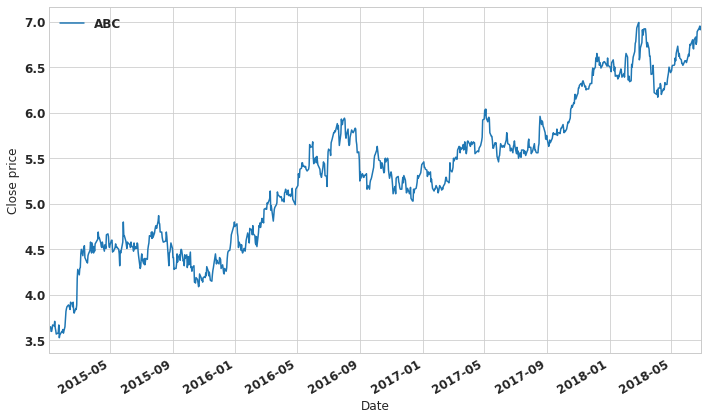

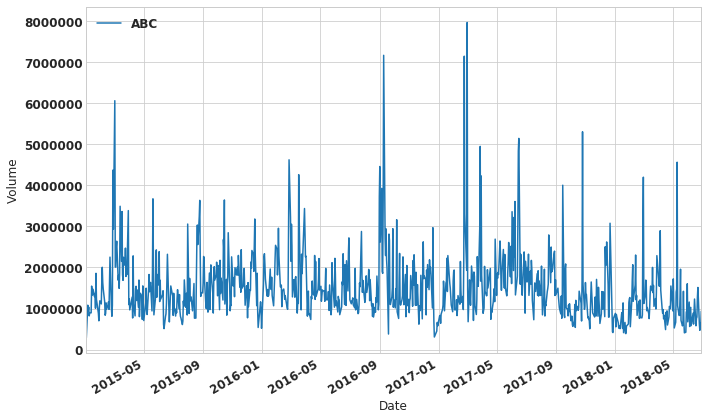

<Figure size 432x288 with 0 Axes>

In [19]:
def plot_prices(df, ylab):
    plt.style.use('seaborn-whitegrid')
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

    plt.rc('font', **font)
    df.plot(figsize = (10, 6))
    plt.legend(loc = 2)
    plt.ylabel(ylab)
   
    plt.tight_layout()
#     plt.savefig(figname+'.png', dpi=100)

    plt.show()
    plt.draw()

plot_prices(df_close_filled['ABC'], 'Close price')
plot_prices(df_volume_filled['ABC'], 'Volume')




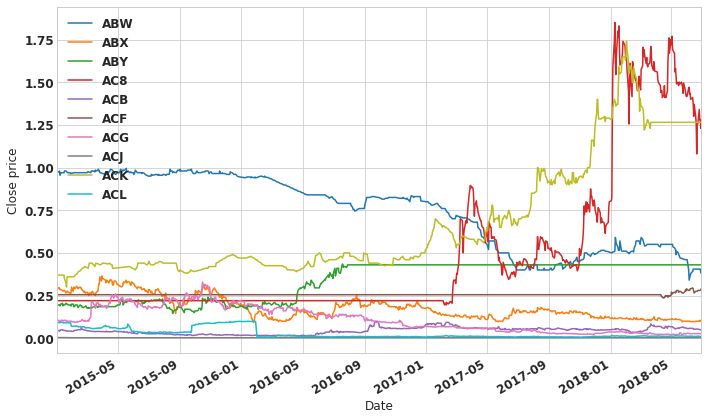

<Figure size 432x288 with 0 Axes>

In [20]:
plot_prices(df_close_filled.iloc[:, 40:50], 'Close price')

In [21]:
 def convert_to_returns(df):
    """Converts a df with a single column of close or adj close to
    returns per period."""
    #print(df)
    rf = df.copy()
    returns = rf/rf.shift(1) - 1
    future_returns = (rf.shift(1)/rf)  - 1
    #print(r)
    return [returns, future_returns]

df_returns = df_close_filled.copy()
df_future_returns = df_close_filled.copy()
cols=df_close_filled.columns
returns_dict = {}
fut_returns_dict={}
for i in tqdm(range(len(cols))):
    if  i < len(cols):
        returns, future_returns = (convert_to_returns(df_returns[cols[i]]))
        returns_dict[i] = returns
        fut_returns_dict[i] = future_returns
        df_future_returns[cols[i]] = pd.DataFrame(future_returns)
        df_returns[cols[i]]=pd.DataFrame(returns).T
        df_returns[cols[i]] = returns

pct_pandas = df_close_filled[cols[0]].pct_change()
print(df_returns[cols[0]].iloc[-10:], '\n', pct_pandas[-10:])

100%|█████████████████████████████████████| 2755/2755 [00:21<00:00, 126.42it/s]


Date
2018-06-18    0.006993
2018-06-19    0.013889
2018-06-20   -0.013699
2018-06-21    0.027778
2018-06-22   -0.054054
2018-06-25    0.000000
2018-06-26    0.000000
2018-06-27    0.014286
2018-06-28    0.042254
2018-06-29    0.000000
Name: 1AD, dtype: float64 
 Date
2018-06-18    0.006993
2018-06-19    0.013889
2018-06-20   -0.013699
2018-06-21    0.027778
2018-06-22   -0.054054
2018-06-25    0.000000
2018-06-26    0.000000
2018-06-27    0.014286
2018-06-28    0.042254
2018-06-29    0.000000
Name: 1AD, dtype: float64


In [22]:
display(df_returns.head())
display(df_future_returns.head())

Ticker,1AD,1AG,1AL,1PG,1ST,3DM,3DP,3PL,4CE,4DS,...,ZNC,ZNO,ZNT,ZNZ,ZOZI,ZRL,ZTA,ZUSD,ZYB,ZYUS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,0.0,0.0,0.0,0.041152,0.0,0.0,0.0,-0.084071,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.044776,0.00000,0.0,0.0,0.0
2015-01-06,0.0,0.0,0.0,-0.015810,0.0,0.0,0.0,0.004831,0.0,0.0,...,0.0,0.0,0.0,-0.002273,0.0,-0.002381,0.00000,0.0,0.0,0.0
2015-01-07,0.0,0.0,0.0,0.004016,0.0,0.0,0.0,-0.014423,0.0,0.0,...,0.0,0.0,0.0,0.004556,0.0,-0.002387,0.00000,0.0,0.0,0.0
2015-01-08,0.0,0.0,0.0,0.004000,0.0,0.0,0.0,0.014634,0.0,0.0,...,0.0,0.0,0.0,0.004535,0.0,-0.002392,0.02381,0.0,0.0,0.0


Ticker,1AD,1AG,1AL,1PG,1ST,3DM,3DP,3PL,4CE,4DS,...,ZNC,ZNO,ZNT,ZNZ,ZOZI,ZRL,ZTA,ZUSD,ZYB,ZYUS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,0.0,0.0,0.0,-0.039526,0.0,0.0,0.0,0.091787,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,-0.042857,0.000000,0.0,0.0,0.0
2015-01-06,0.0,0.0,0.0,0.016064,0.0,0.0,0.0,-0.004808,0.0,0.0,...,0.0,0.0,0.0,0.002278,0.0,0.002387,0.000000,0.0,0.0,0.0
2015-01-07,0.0,0.0,0.0,-0.004000,0.0,0.0,0.0,0.014634,0.0,0.0,...,0.0,0.0,0.0,-0.004535,0.0,0.002392,0.000000,0.0,0.0,0.0
2015-01-08,0.0,0.0,0.0,-0.003984,0.0,0.0,0.0,-0.014423,0.0,0.0,...,0.0,0.0,0.0,-0.004515,0.0,0.002398,-0.023256,0.0,0.0,0.0


In [23]:
def replace_nans(df):
    df_filled  = df.fillna(0)
    return df_filled

df_future_returns_filled  = replace_nans(df_future_returns)
df_returns_filled  = replace_nans(df_returns)

display(df_future_returns_filled.head())
display(df_returns_filled.head())

Ticker,1AD,1AG,1AL,1PG,1ST,3DM,3DP,3PL,4CE,4DS,...,ZNC,ZNO,ZNT,ZNZ,ZOZI,ZRL,ZTA,ZUSD,ZYB,ZYUS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2015-01-05,0.0,0.0,0.0,-0.039526,0.0,0.0,0.0,0.091787,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,-0.042857,0.000000,0.0,0.0,0.0
2015-01-06,0.0,0.0,0.0,0.016064,0.0,0.0,0.0,-0.004808,0.0,0.0,...,0.0,0.0,0.0,0.002278,0.0,0.002387,0.000000,0.0,0.0,0.0
2015-01-07,0.0,0.0,0.0,-0.004000,0.0,0.0,0.0,0.014634,0.0,0.0,...,0.0,0.0,0.0,-0.004535,0.0,0.002392,0.000000,0.0,0.0,0.0
2015-01-08,0.0,0.0,0.0,-0.003984,0.0,0.0,0.0,-0.014423,0.0,0.0,...,0.0,0.0,0.0,-0.004515,0.0,0.002398,-0.023256,0.0,0.0,0.0


Ticker,1AD,1AG,1AL,1PG,1ST,3DM,3DP,3PL,4CE,4DS,...,ZNC,ZNO,ZNT,ZNZ,ZOZI,ZRL,ZTA,ZUSD,ZYB,ZYUS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0
2015-01-05,0.0,0.0,0.0,0.041152,0.0,0.0,0.0,-0.084071,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.044776,0.00000,0.0,0.0,0.0
2015-01-06,0.0,0.0,0.0,-0.015810,0.0,0.0,0.0,0.004831,0.0,0.0,...,0.0,0.0,0.0,-0.002273,0.0,-0.002381,0.00000,0.0,0.0,0.0
2015-01-07,0.0,0.0,0.0,0.004016,0.0,0.0,0.0,-0.014423,0.0,0.0,...,0.0,0.0,0.0,0.004556,0.0,-0.002387,0.00000,0.0,0.0,0.0
2015-01-08,0.0,0.0,0.0,0.004000,0.0,0.0,0.0,0.014634,0.0,0.0,...,0.0,0.0,0.0,0.004535,0.0,-0.002392,0.02381,0.0,0.0,0.0


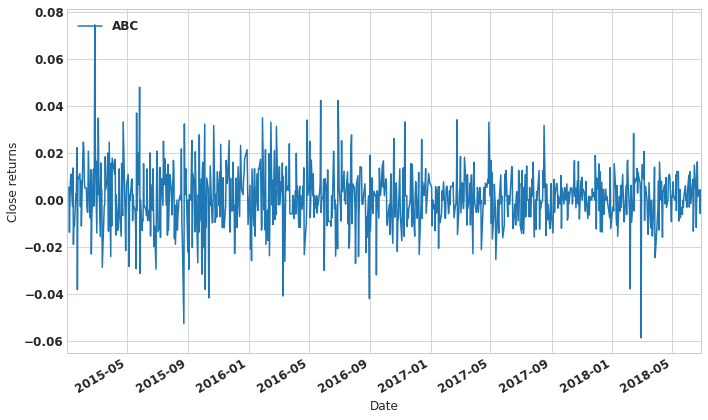

<Figure size 432x288 with 0 Axes>

In [24]:
plot_prices(df_returns['ABC'], 'Close returns')

#### Calculating High/Low ratio

In [25]:
# Creating raios high/low for each ticker on each day
df_ratio_filled=(df_high_filled/df_low_filled)
df_ratio_filled.head()

Ticker,1AD,1AG,1AL,1PG,1ST,3DM,3DP,3PL,4CE,4DS,...,ZNC,ZNO,ZNT,ZNZ,ZOZI,ZRL,ZTA,ZUSD,ZYB,ZYUS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,1.192308,1.125,1.1,1.068966,1.375,1.454545,1.128205,1.055300,1.111111,1.566667,...,1.0,1.333333,1.12,1.022727,1.0,1.0,1.0,1.0,1.219512,1.001627
2015-01-05,1.192308,1.125,1.1,1.061224,1.375,1.454545,1.128205,1.111111,1.111111,1.566667,...,1.0,1.333333,1.12,1.022727,1.0,1.0,1.0,1.0,1.219512,1.001627
2015-01-06,1.192308,1.125,1.1,1.041322,1.375,1.454545,1.128205,1.039604,1.111111,1.566667,...,1.0,1.333333,1.12,1.006865,1.0,1.0,1.0,1.0,1.219512,1.001627
2015-01-07,1.192308,1.125,1.1,1.041667,1.375,1.454545,1.128205,1.050000,1.111111,1.566667,...,1.0,1.333333,1.12,1.004549,1.0,1.0,1.0,1.0,1.219512,1.001627
2015-01-08,1.192308,1.125,1.1,1.044534,1.375,1.454545,1.128205,1.014493,1.111111,1.566667,...,1.0,1.333333,1.12,1.002261,1.0,1.0,1.0,1.0,1.219512,1.001627


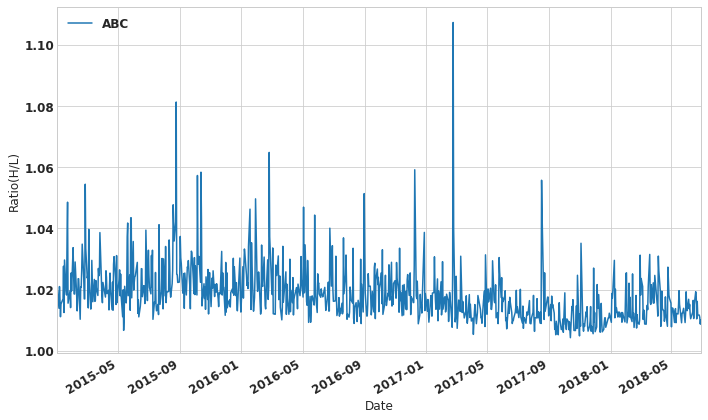

<Figure size 432x288 with 0 Axes>

In [26]:
plot_prices(df_ratio_filled['ABC'], 'Ratio(H/L)')

#### Calculating cumulative returns

In [27]:
# Calculating cumulative returns
daily_return_cum = (1 + df_returns_filled).cumprod()
daily_return_cum.head()

Ticker,1AD,1AG,1AL,1PG,1ST,3DM,3DP,3PL,4CE,4DS,...,ZNC,ZNO,ZNT,ZNZ,ZOZI,ZRL,ZTA,ZUSD,ZYB,ZYUS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.0,1.0,1.000000,1.0,1.000000,1.00000,1.0,1.0,1.0
2015-01-05,1.0,1.0,1.0,1.041152,1.0,1.0,1.0,0.915929,1.0,1.0,...,1.0,1.0,1.0,1.000000,1.0,1.044776,1.00000,1.0,1.0,1.0
2015-01-06,1.0,1.0,1.0,1.024691,1.0,1.0,1.0,0.920354,1.0,1.0,...,1.0,1.0,1.0,0.997727,1.0,1.042289,1.00000,1.0,1.0,1.0
2015-01-07,1.0,1.0,1.0,1.028807,1.0,1.0,1.0,0.907080,1.0,1.0,...,1.0,1.0,1.0,1.002273,1.0,1.039801,1.00000,1.0,1.0,1.0
2015-01-08,1.0,1.0,1.0,1.032922,1.0,1.0,1.0,0.920354,1.0,1.0,...,1.0,1.0,1.0,1.006818,1.0,1.037313,1.02381,1.0,1.0,1.0


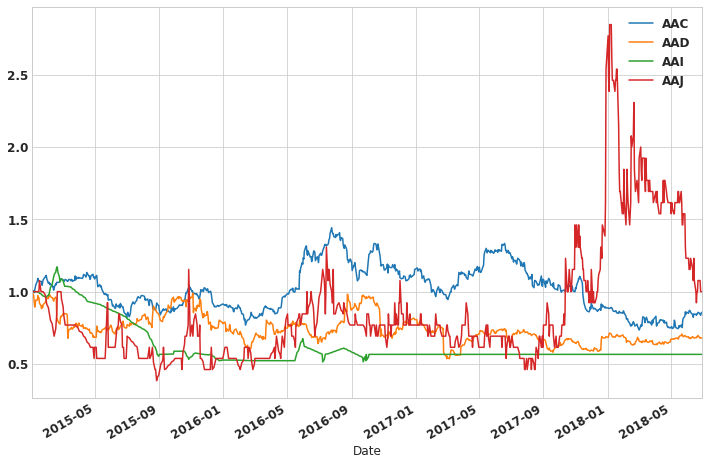

In [28]:
daily_return_cum.iloc[:,21:25].plot(figsize = (12,8))
plt.legend()
figname = 'cum_ret'
plt.savefig(figname+'.png', dpi=100)
plt.show()

## Exploratory data analysis (EDA)

### Testing for missing values

In [29]:
def missing_values(df):
    decision=df.isnull().values.any()
    return decision

print(missing_values(df_returns_filled))
print(missing_values(df_future_returns_filled))
print(missing_values(df_close_filled))
print(missing_values(df_ratio_filled))
print(missing_values(df_volume_filled))

False
False
False
True
False


The transformed data frames ````close_returns````, ````ratio_highlow```` and ````Volume```` do not exhibit any missing values.

### Checking data distribution

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


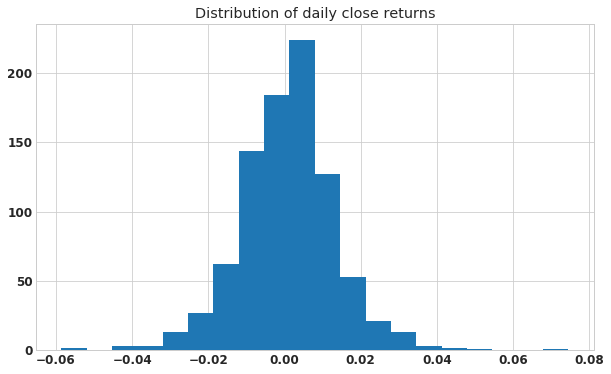

In [30]:
# plot daily % change values histogram for ABC using 20 bins
plt.figure(figsize = (10,6))
daily_pct_change_ABC =df_returns_filled['ABC']
plt.hist(daily_pct_change_ABC, bins = 20)
plt.title('Distribution of daily close returns')
figname = 'daily_pct_ABC'
plt.savefig(figname+'.png', dpi=100)
plt.show()

In [31]:
daily_pct_change_ABC.describe()

count    883.000000
mean       0.000817
std        0.012740
min       -0.058655
25%       -0.007036
50%        0.001527
75%        0.007901
max        0.074550
Name: ABC, dtype: float64

In [32]:
daily_pct_change_ABC.describe(percentiles=[0.025, 0.5, 0.975])

count    883.000000
mean       0.000817
std        0.012740
min       -0.058655
2.5%      -0.024516
50%        0.001527
97.5%      0.026152
max        0.074550
Name: ABC, dtype: float64

#### Distribution for multiple ticker codes

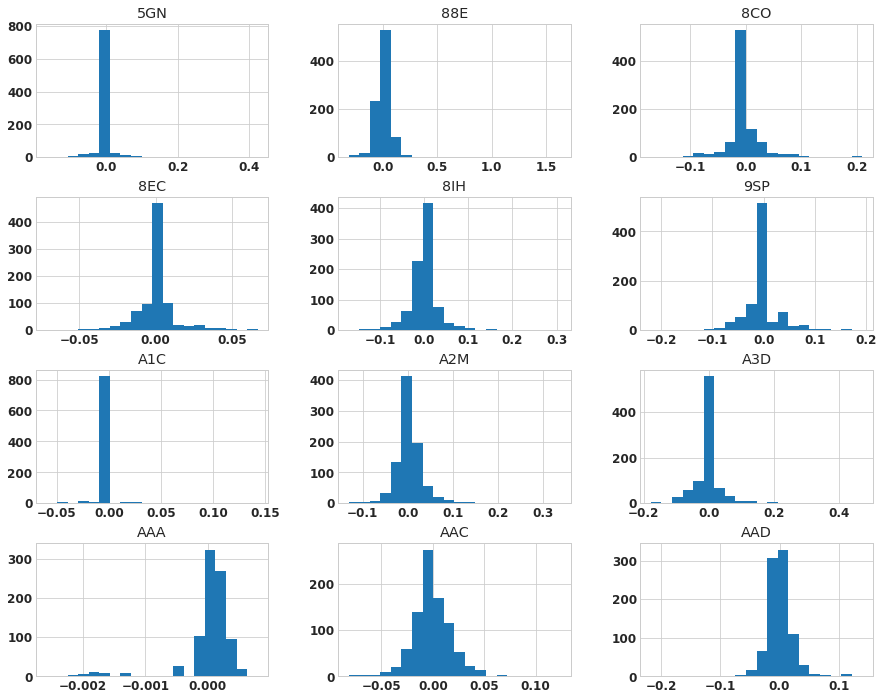

In [33]:
df_returns_filled.iloc[:,11:23].hist(bins=20,  figsize=(15,12))
figname = 'daily_pct_dist'
plt.savefig(figname+'.png', dpi=100)
plt.show()

#### Probability plot (qqplot)

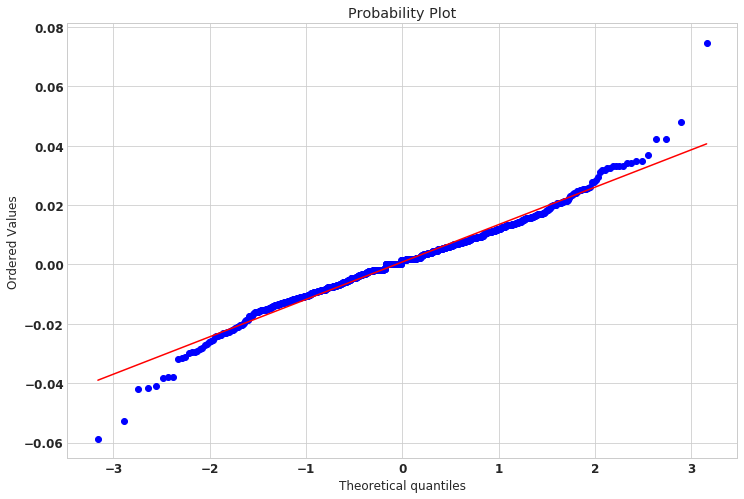

In [34]:
# Another way to check distribution of close returns, probability plot tells how close our data to normal distribution 
#A straight blue line would be a exhibit perfect normal distribution 
plothandle = plt.figure(figsize=(12,8))
ax = plothandle.add_subplot(111)
stats.probplot(df_returns_filled['ABC'], dist='norm', plot = ax)
plt.show();

#### Correlation matrix

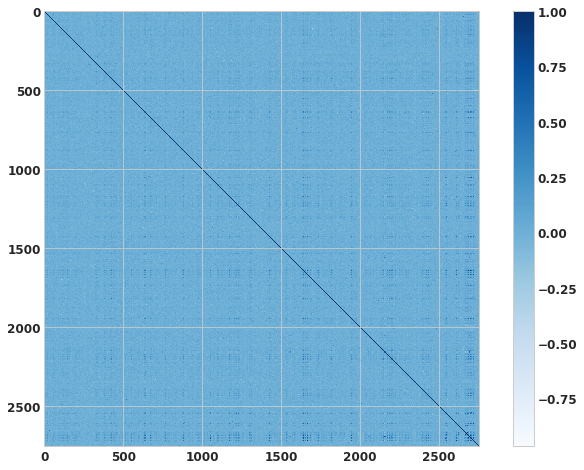

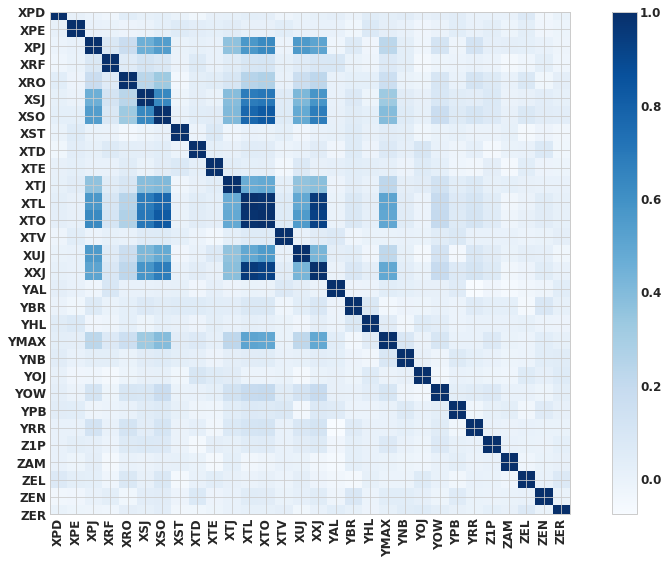

In [35]:
# Inspecting correlation matrix
plt.figure(figsize = (12,8))
plt.imshow(df_returns_filled.corr(), cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
# figname = 'corr_mtx1'
# plt.savefig(figname+'.png', dpi=100)
plt.show()
plt.figure(figsize = (12,8))
plt.imshow(df_returns_filled.iloc[:,-50:-20].corr(), cmap=plt.cm.Blues, interpolation='nearest')
tick_marks = [i for i in range(len(df_returns_filled.iloc[:, -50:-20].columns))]
plt.xticks(tick_marks, df_returns_filled.iloc[:, -50:-20].columns, rotation='vertical')
plt.yticks(tick_marks, df_returns_filled.iloc[:, -50:-20].columns)
plt.colorbar()
# figname = 'corr_mtx'
# plt.savefig(figname+'.png', dpi=100)
plt.tight_layout()
plt.show()


#### Replacing outliers

In [36]:
#replace outliers with 5% confidence
def outlier_quantile(df):
    df_new = df.copy()
    down_qnt = df_new.quantile(0.05)
    outliers_low = (df_new < down_qnt)
    df_new[outliers_low] = np.nan
    df_new.fillna(down_qnt, inplace=True)
    return df_new
# Replace outliers based on median
def outlier_median(df):
    df_new = df.copy()
    median = df_new.median()
    std = df_new.std()
    outliers = (df_new - median).abs() > std
    df_new[outliers] = np.nan
    df_new.fillna(median, inplace=True)
    return df_new

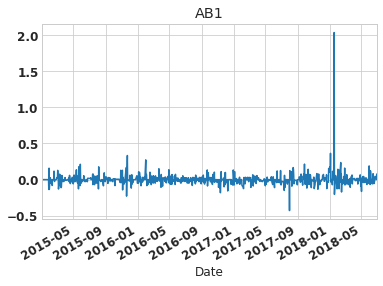

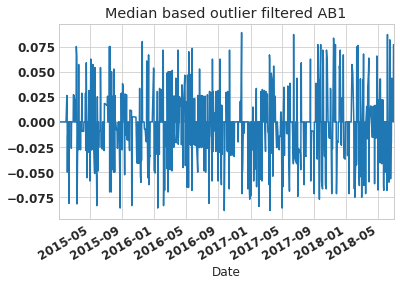

In [37]:
df_returns_filled_med=outlier_median(df_returns_filled)
df_returns_filled_qnt=outlier_quantile(df_returns_filled)

df_returns_filled.iloc[:, 31].plot()
plt.title('AB1')
plt.show()
df_returns_filled_med.iloc[:, 31].plot()
plt.title('Median based outlier filtered AB1')
plt.show()

#### Comparison of daily close returns for multiple stocks

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


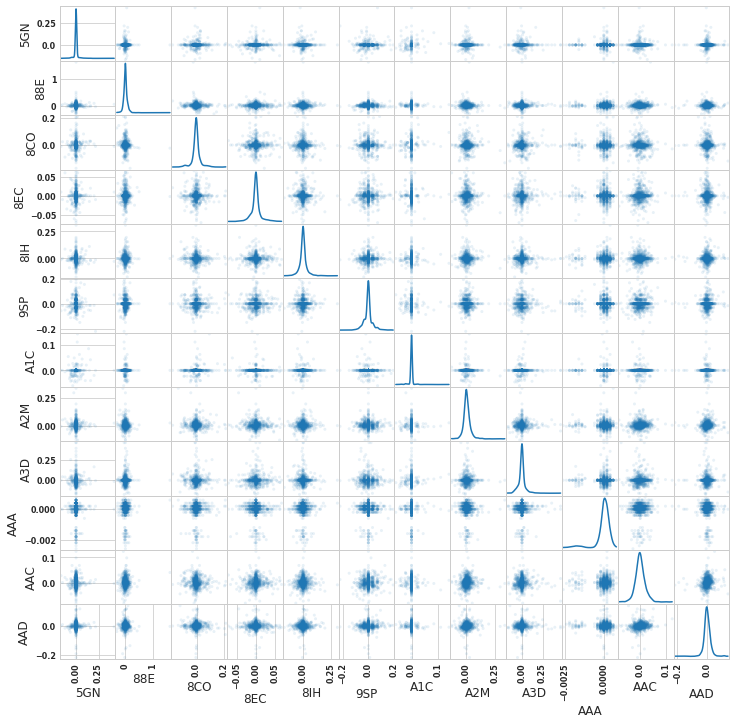

In [38]:
# multiple stocks against each other, with KDE at the diagonal, alpha controls the transperency of the graph
from pandas.plotting import scatter_matrix
_=scatter_matrix(df_returns_filled.iloc[:, 11:23], diagonal='kde', alpha=0.1,
                      figsize=(12,12))
figname = 'scatter_mtx'
plt.savefig(figname+'.png', dpi=100)

#### Anlysing timeseries with moving windows

In [39]:
close_price_ABC=df_close_filled['ABC']
close_price_ABC['2015'].head()

Date
2015-01-02    3.63
2015-01-05    3.65
2015-01-06    3.60
2015-01-07    3.60
2015-01-08    3.63
Name: ABC, dtype: float64

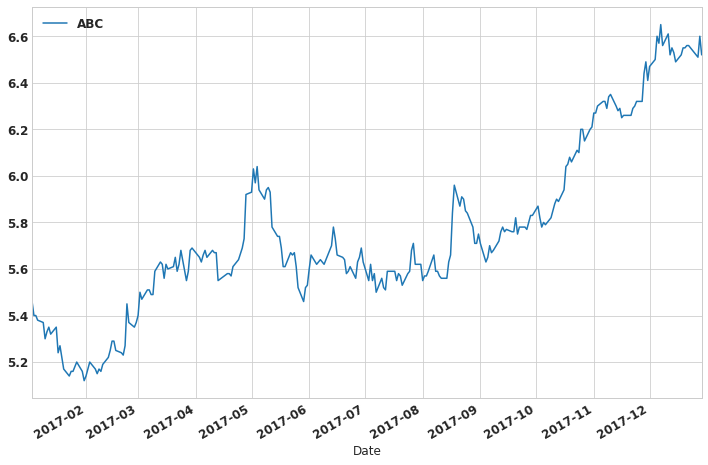

In [40]:
close_price_ABC_2017 =  close_price_ABC['2017']
close_price_ABC_2017.plot(figsize = (12,8), legend = True)
plt.show()

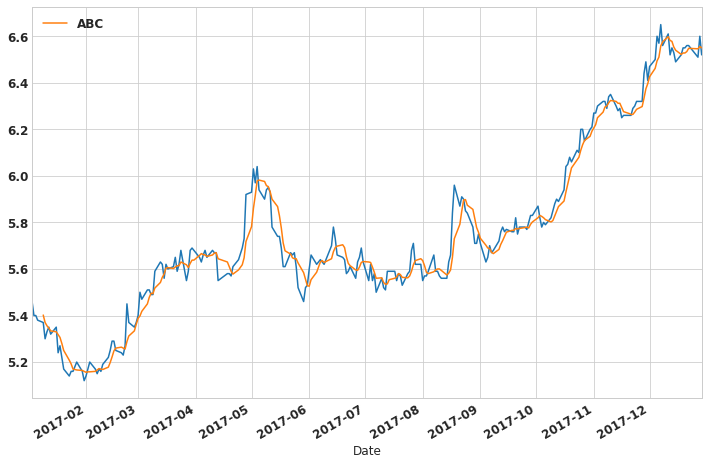

In [41]:
close_price_ABC_2017.plot(figsize = (12,8))
moving_avg = close_price_ABC_2017.rolling(5).mean()
moving_avg.plot(figsize = (12,8), legend = True)

C:\Users\mqadar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Mean absolute deviation')

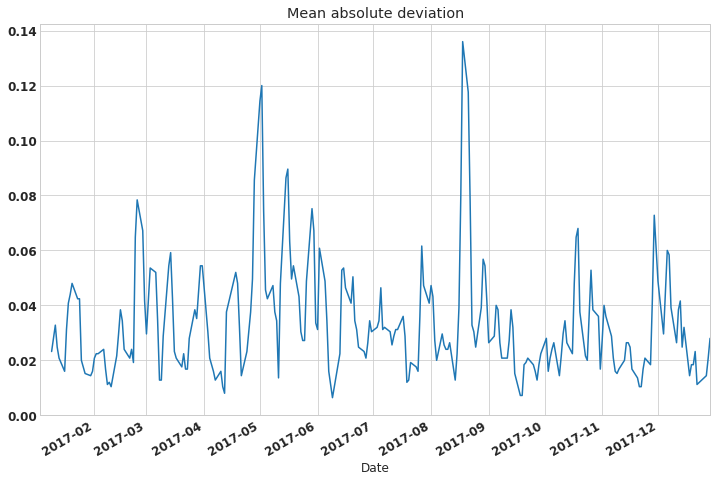

In [42]:
#Mean absolute deviation
mean_abs_dev = lambda x: np.fabs(x - x.mean()).mean()
close_price_ABC_2017.rolling(5).apply(mean_abs_dev).plot(figsize=(12,8))
plt.title('Mean absolute deviation')

#### Volatility calculation

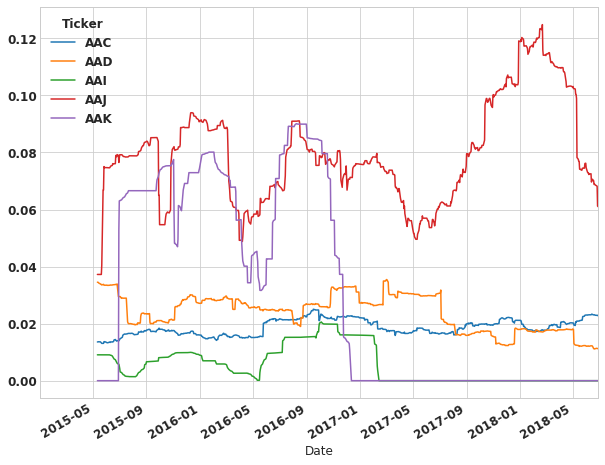

In [66]:
# use a minimum of 90 days
min_periods = 90
# calculate the rolling standard deviation
vol = (df_returns_filled.iloc[:,21:26].rolling(min_periods).std()) * \
                     np.sqrt(min_periods)
# plot it
_ = vol.plot(figsize=(10, 8));


#### Calculation of rolling correlation

In [61]:
window=252
rolling_corr = df_returns_filled['ABC'].rolling(window).corr(df_returns_filled['ABP']).dropna()
rolling_corr.head()

Date
2015-12-29    0.455703
2015-12-30    0.455784
2015-12-31    0.457113
2016-01-04    0.458205
2016-01-05    0.461544
dtype: float64

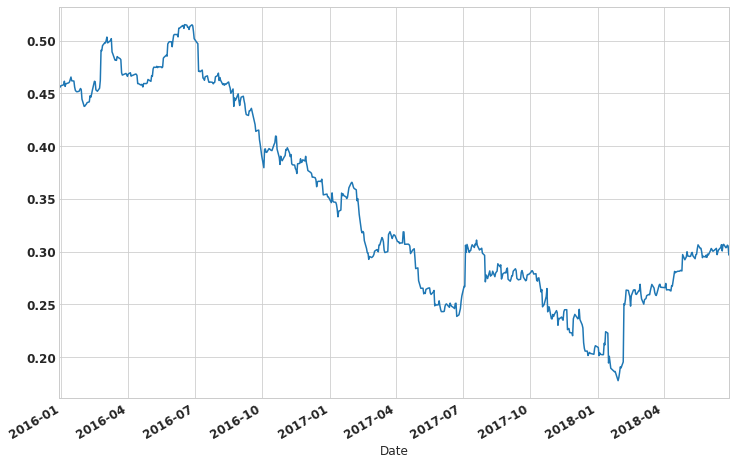

In [62]:
rolling_corr.plot(figsize=(12,8));

#### Least square regression of rolling close returns

In [64]:
from sklearn import linear_model

def rolling_beta(X, y, idx, window=252):

    assert len(X)==len(y)

    out_dates = []
    out_beta = []

    model_ols = linear_model.LinearRegression()

    for i in range(0, len(X)-window):        
        ilast = i+window

        model_ols.fit(X[i:ilast], y[i:ilast])

        #store output
        out_dates.append(idx[ilast])
        out_beta.append(model_ols.coef_[0][0])

    return pd.DataFrame({'beta':out_beta}, index=out_dates)
df_beta =rolling_beta(df_returns_filled['ABC'].values.reshape(-1, 1), df_returns_filled['ABP'].values.reshape(-1, 1), df_returns_filled.index.values, 255)
# df_beta['beta'].plot(figsize = (12,8))
df_beta

,beta
2016-01-05,0.484949
2016-01-06,0.487831
2016-01-07,0.483278
2016-01-08,0.487347
2016-01-11,0.486162
...,...
2018-06-25,0.359059
2018-06-26,0.347467
2018-06-27,0.346640
2018-06-28,0.350205


### Forecasting
#### Experiment 1

#### Data preparation

In [47]:
# Generate random integeres
from random import randint
num = 5
value = np.zeros(num)
for i in range(num):
    value[i] = randint(0,2700)
value
    

array([1003., 1854., 1969., 1889.,  888.])

In [48]:
# Or manually select a range of columns
df_returns_selected=df_returns_filled.iloc[:, -50:-30]
df_returns_selected=df_returns_selected.loc[:,~df_returns_selected.columns.duplicated()]
df_returns_selected = drop_constant_columns(df_returns_selected)
df_returns_selected.shape

(883, 20)

In [49]:
yt =df_returns_selected

In [71]:
# Calculate a 30 days historical volatility
win =30
vol_t = yt.rolling(window = win, center = True).std()
vol_t

Ticker,XPD,XPE,XPJ,XRF,XRO,XSJ,XSO,XST,XTD,XTE,XTJ,XTL,XTO,XTV,XUJ,XXJ,YAL,YBR,YHL,YMAX
Date,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


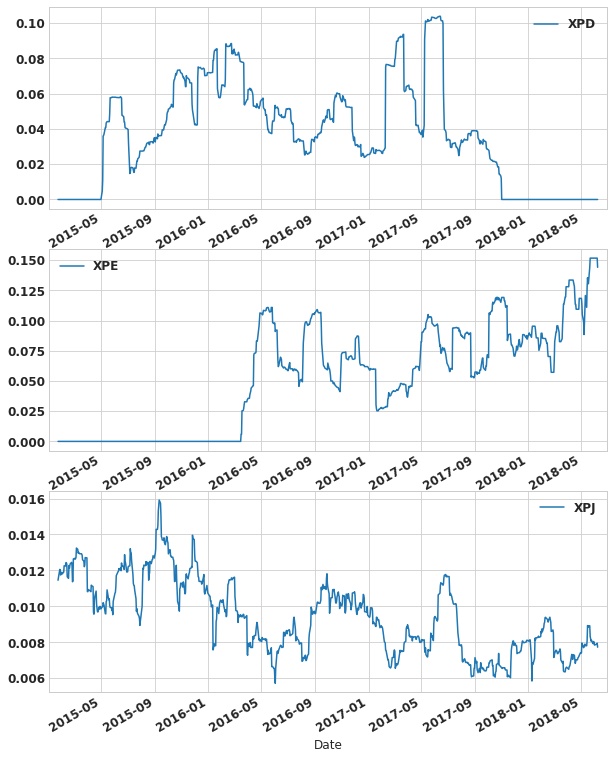

In [51]:
# Lets show first few timeseries in newly created timeseries
rows=yt.shape[1]-17
 

fig, ax = plt.subplots(rows, 1)
for i in range(rows):
    vol_t.iloc[:,i].plot(legend = True,ax =ax[i],figsize=(10,14))
plt.show()

#### Creating features

In [52]:
x1=np.log (( vol_t.shift ( 1 ) / vol_t.shift( 2 ) ) * vol_t.shift ( 1 ) +np.finfo(np.float32).eps) 
x2=np.log (( vol_t.shift ( 1 ) / vol_t.shift( 3 ) ) * vol_t.shift ( 1 ) +np.finfo(np.float32).eps) 
x3=np.log (( vol_t.shift ( 1 ) / vol_t.shift( 4 ) ) * vol_t.shift ( 1 ) +np.finfo(np.float32).eps) 
x4=np.log (( vol_t.shift ( 1 ) / vol_t.shift( 5 ) ) * vol_t.shift ( 1 ) +np.finfo(np.float32).eps) 
x5=np.log (( vol_t.shift ( 1 ) / vol_t.shift( 6 ) ) * vol_t.shift ( 1 ) +np.finfo(np.float32).eps) 

In [53]:
data = pd.concat([vol_t, x1, x2,x3,x4,x5], axis = 1)
data.shape

(883, 120)

In [54]:
headers = []
col=yt.columns
for i in range(6):
    if i ==0:
        headers.append(col)
    else:   
        headers.append(col+'-'+str(i))
headers=np.reshape(np.array(headers[:]), (1,len(col)*6)).tolist()

In [55]:
data.columns = headers
data=data.replace([np.inf, -np.inf], np.nan)
data = drop_constant_columns(data)
data = data.dropna(axis=0, thresh=15, how="any")
data = data.interpolate(method = 'linear').bfill()
data.shape

(855, 120)

In [72]:
# Creating target (y) and feature (x) variables
cols_y = col
y = data[cols_y]
cols_x= headers[0][len(col):]
X = data[cols_x]
# dates=X.reset_index()['Date']


In [ ]:
# Scaling data to lie within [0, 1]
num_attr = len(cols_x)
scaler_x = preprocessing.MinMaxScaler(feature_range=(-1,1))
X = np.array(X).reshape((len(X), num_attr))
X = scaler_x.fit_transform(X)
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print (" Shape of x_train is ",X_train.shape)

print (" Shape of x_test is ",X_test.shape)


In [ ]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)

In [ ]:
y_pred = clf.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=cols_y)
y_test = pd.DataFrame(y_test, columns=cols_y)

In [ ]:
def calc_mse(y, y_pred):
    mse=np.square(y - y_pred).mean()
    return mse
mse = []
for i in range(y_test.shape[1]):
    mse.append(calc_mse(y_test.iloc[:,i], y_pred.iloc[:,i]))

min_idx= mse.index(min(mse))
total_mse = np.sum(mse)
print(total_mse, min(mse))

In [ ]:
def plotfigures(y_pred, y_test, rows):
    fig, axes = plt.subplots(rows, 1)
    for i in range(rows):
        y_pred.iloc[:, i].plot(legend = True, ax = axes[i], figsize = (12,10))
        y_test.iloc[:, i].plot(ax = axes[i])  
    plt.show()

plotfigures(y_pred, y_test, 3)

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=0))

scores_mrf = cross_val_score(regr_multirf, X_train, y_train, cv=5)
print("Cross-Val accuracy MultiOutputRegressor: %0.2f (+/- %0.2f)" % (scores_mrf.mean(), scores_mrf.std() * 2))

regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=2)

scores_rf = cross_val_score(regr_rf, X_train, y_train, cv=5)
print("Cross-Val accuracy RandomForestRegressor: %0.2f (+/- %0.2f)" % (scores_rf.mean(), scores_rf.std() * 2))
# Train on using MultiOutputRegressor and RandomForestRegressor
regr_multirf.fit(X_train, y_train)
regr_rf.fit(X_train, y_train)
# Predict on new data
y_multirf = regr_multirf.predict(X_test)
y_rf = regr_rf.predict(X_test)

score_multirf=regr_multirf.score(X_test, y_test)
score_rf=regr_rf.score(X_test, y_test)
print('Score using MultiRegRandomForest {} and RandomForest  {}'.format(score_multirf, score_rf))

In [ ]:
GRB=MultiOutputRegressor(GradientBoostingRegressor(random_state=0))
GRB.fit(X_train, y_train)
y_grb=GRB.predict(X_test)
print('Score {}'.format(GRB.score(X_test,y_test)))

In [ ]:
y_multirf = pd.DataFrame(y_multirf, columns=cols_y)
y_rf = pd.DataFrame(y_rf, columns=cols_y)
y_grb = pd.DataFrame(y_grb, columns=cols_y)
mse1 = []
mse2 = []
mse3 = []
for i in range(y_test.shape[1]):
    mse1.append(calc_mse(y_test.iloc[:,i], y_multirf.iloc[:,i]))
    mse2.append(calc_mse(y_test.iloc[:,i], y_multirf.iloc[:,i]))
    mse3.append(calc_mse(y_test.iloc[:,i], y_grb.iloc[:,i]))

mse1_min_idx= mse1.index(min(mse1))
mse2_min_idx= mse2.index(min(mse2))
mse3_min_idx= mse3.index(min(mse3))

total_mse1 = np.sum(mse1)
total_mse2 = np.sum(mse2)
total_mse3 = np.sum(mse3)
print('Total MSE for MRFR ' + str(total_mse1) + ' and minimum MSE ' + str(min(mse1)))
print('Total MSE for FR '   + str(total_mse2) + ' and minimum MSE ' + str(min(mse2))) 
print('Total MSE for GRB '  + str(total_mse3) + ' and minimum MSE ' + str(min(mse3)))
      
print('Ticker code with minimum MSE using MultiRegressorRandomForests: {}'.format(cols_y[mse1_min_idx] ))
print('Ticker code with minimum MSE using RandomForests: {}'.format(cols_y[mse2_min_idx]) )
print('Ticker code with minimum MSE using GradientBoosting: {}'.format(cols_y[mse3_min_idx]) )      

In [ ]:
plotfigures(y_grb, y_test, 5)

#### Experiment 2


In [ ]:
forecasting_cols = df_returns_filled.columns

In [ ]:
import math


def forecast_price(numofcols, fore_cols, clf):
    acc = []
    dict_forecast ={}
    msee = []
    forecasted_cols = []
    returns_data ={}
    orig_cols = []
    forecasting_cols=fore_cols
    for j  in range(numofcols):
        df = pd.DataFrame()

        close = df_close_filled.iloc[:,j]
        ratio = df_ratio_filled.iloc[:,j]
        volume = df_volume_filled.iloc[:,j]
        PCT_change = df_returns_filled.iloc[:,j]
        cum_change = daily_return_cum.iloc[:,j]
        
        
        df['PCT_change'] = PCT_change
        df['close'] = close
        df['ratio'] = ratio
        df['volume'] = volume
        df['cum_change'] = cum_change

        col_to_forecast = 'PCT_change'
        df=df.interpolate(method='linear', axis=0)
        forecast_out = int(math.ceil(0.05 * len(df)))   # Create number of rows to add as forecast
        df['label'] = df[col_to_forecast].shift(-forecast_out)

        X = np.array(df.drop(['label'], 1))
        X = preprocessing.scale(X)
        
        X_future = X[-forecast_out:]
        X = X[:-forecast_out]
        df.dropna(inplace=True)

        y = np.array(df['label'])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        clf.fit(X_train, y_train)
        confidence = clf.score(X_test, y_test)
        acc.append(confidence)
        y_pred = clf.predict(X_test)
        mse = calc_mse(y_test, y_pred)
        msee.append(calc_mse(y_test, y_pred))

        print('Accuracy '+ '{:.4f}'.format(confidence) + ' for ' +forecasting_cols[j]  + ' and MSE is: ' + str(mse) )

        forecast_set = clf.predict(X_future)
        new_str = forecasting_cols[j]+'-f' 
        forecasted_cols.append(new_str)
        df[new_str] = np.nan
        orig_cols.append(forecasting_cols[j])
        
        last_date = df.iloc[-1].name
        last_unix = last_date.timestamp()
        one_day = 86400
        next_unix = last_unix + one_day
        
        for i in forecast_set:
            next_date = datetime.fromtimestamp(next_unix)
            next_unix += 86400
            df.loc[next_date] =  [np.nan for _ in range(len(df.columns)-1)]  + [i]
        
        dict_forecast[j]=df[new_str]
        returns_data[j] =  df['PCT_change']
    return [dict_forecast, returns_data, orig_cols,forecasted_cols, acc, mse]

In [ ]:

def forecast_price_main(num_cols_to_use, fore_cols,clf):
    dict_forecast, returns_data, orig_col, forecasted_col,acc,mse=forecast_price(num_cols_to_use, fore_cols, clf)
    forecast_result=pd.DataFrame(dict_forecast)
    returns_price =pd.DataFrame(returns_data)
    forecast_result.columns = forecasted_col
    returns_price.columns = orig_col
    return [returns_price, forecast_result, acc, mse]

In [ ]:
cols = df_returns_filled.columns
num_cols_to_use = 10
clf_reg = LinearRegression()
returns_price_reg, forecast_result_reg, acc_reg, mse_reg=forecast_price_main(num_cols_to_use, cols[:num_cols_to_use],clf_reg)

In [ ]:
def plot_single_forecast_tseries(close_price,forecast_result, num, title):
    if num < close_price.shape[1]:
        close_price.iloc[:,num].plot(figsize = (14,10))
        forecast_result.iloc[:,num].plot()
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel('Returns')
        plt.title(title)
        plt.show()


plot_single_forecast_tseries(returns_price_reg,forecast_result_reg, 1, 'Linear Regression')
print('Total MSE {:0.9f}'.format(np.sum(mse_reg)))

In [ ]:
clf_knn = KNeighborsRegressor()
close_price_knn, forecast_result_knn, acc_knn, mse_knn=forecast_price_main(num_cols_to_use, cols[:num_cols_to_use],clf_knn)

In [ ]:
plot_single_forecast_tseries(close_price_knn,forecast_result_knn, 1, 'KNN')
print('Total MSE {:0.9f}'.format(np.sum(mse_knn)))

In [ ]:
clf_rfg = RandomForestRegressor()
close_price_rfg, forecast_result_rfg, acc_rfg, mse_rfg=forecast_price_main(num_cols_to_use, cols[:num_cols_to_use],clf_rfg)

In [ ]:
plot_single_forecast_tseries(close_price_rfg,forecast_result_rfg, 1, 'Random Forest')
print('Total MSE {:0.9f}'.format(np.sum(mse_rfg)))

In [ ]:
clf_mlp = MLPRegressor(hidden_layer_sizes=(30, ), activation='relu', solver='lbfgs')
returns_price_mlp, forecast_result_mlp, acc_mlp, mse_mlp=forecast_price_main(num_cols_to_use, cols[:num_cols_to_use],clf_mlp)

In [ ]:
plot_single_forecast_tseries(returns_price_mlp,forecast_result_mlp, 1, 'MLP')
print('Total MSE {:0.9f}'.format(np.sum(mse_mlp)))

In [ ]:
clf_gbr = GradientBoostingRegressor(max_depth = 5)
close_price_gbr, forecast_result_gbr, acc_gbr, mse_gbr=forecast_price_main(num_cols_to_use, cols[:num_cols_to_use],clf_gbr)

In [ ]:
plot_single_forecast_tseries(close_price_gbr,forecast_result_gbr, 1, 'GBR')
print('Total MSE {:0.9f}'.format(np.sum(mse_gbr)))